In [1]:
from all_weather.portfolio import Portfolio, Allocation
from all_weather.market import get_multiple_historical_data
from enum import Enum
import pandas as pd

In [2]:
class RebalancePeriod(Enum):
    DAILY = 1
    WEEKLY = 5
    MONTHLY = 21
    QUARTERLY = 63
    ANNUALLY = 252

In [3]:
portfolio = Portfolio(
    value=10000.00,
    allocations=[
        Allocation(percent=0.30, symbol="VOO", description="S&P 500"),
        Allocation(percent=0.40, symbol="VGLT", description="Long-Term Treasury"),
        Allocation(percent=0.15, symbol="VGIT", description="Intermediate-Term Treasury"),
        Allocation(percent=0.075, symbol="GLD", description="Gold"),
        Allocation(percent=0.075, symbol="GSG", description="Commodities"),
    ],
)

symbols = [allocation.symbol for allocation in portfolio.allocations]
data = get_multiple_historical_data(symbols, period="max")

rebalance_period = RebalancePeriod.ANNUALLY  # rebalance every year

last_rebalance_date = None
portfolio_values = pd.DataFrame(columns=['value'])

for timestamp, prices in data.iterrows():
    if not last_rebalance_date:
        # If this is the first iteration, allocate the initial portfolio
        last_rebalance_date = timestamp
        instructions = portfolio.allocate(prices=prices.to_dict())
        for instruction in instructions:
            # Adjust positions
            for position in portfolio.positions:
                    if position.symbol == instruction.symbol:
                        # Adjust position
                        position.quantity += instruction.quantity

                        # Update portfolio
                        portfolio.cash -= instruction.quantity * prices[instruction.symbol]
    else:
        # Check if it's time for rebalancing
        days_since_rebalance = (timestamp - last_rebalance_date).days
        if days_since_rebalance >= rebalance_period.value:
            last_rebalance_date = timestamp
            instructions = portfolio.allocate(prices=prices.to_dict())
            for instruction in instructions:
                # Adjust positions
                for position in portfolio.positions:
                    if position.symbol == instruction.symbol:
                        if instruction.action == "BUY":
                            # Adjust position
                            position.quantity += instruction.quantity

                            # Update portfolio
                            portfolio.cash -= instruction.quantity * prices[instruction.symbol]
                        else:
                            # Adjust position
                            position.quantity -= instruction.quantity
        
                            # Update portfolio
                            portfolio.cash += instruction.quantity * prices[instruction.symbol]


    # Store daily net liquidation value
    portfolio_values.loc[timestamp] = sum(position.quantity * prices[position.symbol] for position in portfolio.positions) + portfolio.cash

# Store the last day
portfolio_values.loc[timestamp] = sum(position.quantity * prices[position.symbol] for position in portfolio.positions) + portfolio.cash

In [ ]:
# Clean up the index
portfolio_values.index = portfolio_values.index.tz_localize(None)
portfolio_values.index.name = "Date"

# Report

In [ ]:
%matplotlib inline

import quantstats as qs

In [ ]:
qs.extend_pandas()

Date
2010-09-09    0.000000
2010-09-10    0.000683
2010-09-13    0.007442
2010-09-14    0.004326
2010-09-15   -0.004070
                ...   
2024-07-08   -0.000587
2024-07-09   -0.000801
2024-07-10    0.002066
2024-07-11    0.002071
2024-07-12    0.001510
Name: value, Length: 3483, dtype: float64

[*********************100%%**********************]  1 of 1 completed


Date
1993-01-29    0.000000
1993-02-01    0.007112
1993-02-02    0.002119
1993-02-03    0.010571
1993-02-04    0.004184
                ...   
2024-07-08    0.001154
2024-07-09    0.000972
2024-07-10    0.009895
2024-07-11   -0.008623
2024-07-12    0.006308
Name: Close, Length: 7919, dtype: float64

/Users/orshemtov/Library/Caches/pypoetry/virtualenvs/all-weather-aMegKsqF-py3.11/lib/python3.11/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2010-09-10   2010-09-10
End Period          2024-07-12   2024-07-12
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       100.0%

Cumulative Return   404.86%      87.96%
CAGR﹪              8.41%        3.2%

Sharpe              0.77         0.97
Prob. Sharpe Ratio  99.77%       99.98%
Sortino             1.08         1.38
Sortino/√2          0.76         0.97
Omega               1.18         1.18

Max Drawdown        -34.1%       -11.57%
Longest DD Days     745          976

Gain/Pain Ratio     0.16         0.18
Gain/Pain (1M)      0.97         1.04

Payoff Ratio        0.89         0.9
Profit Factor       1.16         1.18
Common Sense Ratio  1.1          1.16
CPC Index           0.57         0.59
Tail Ratio          0.95         0.98
Outlier Win Ratio   2.48         7.79
Outlier Loss Ratio  2.61         8.37

MTD                 2.9%         1.3%
3M              

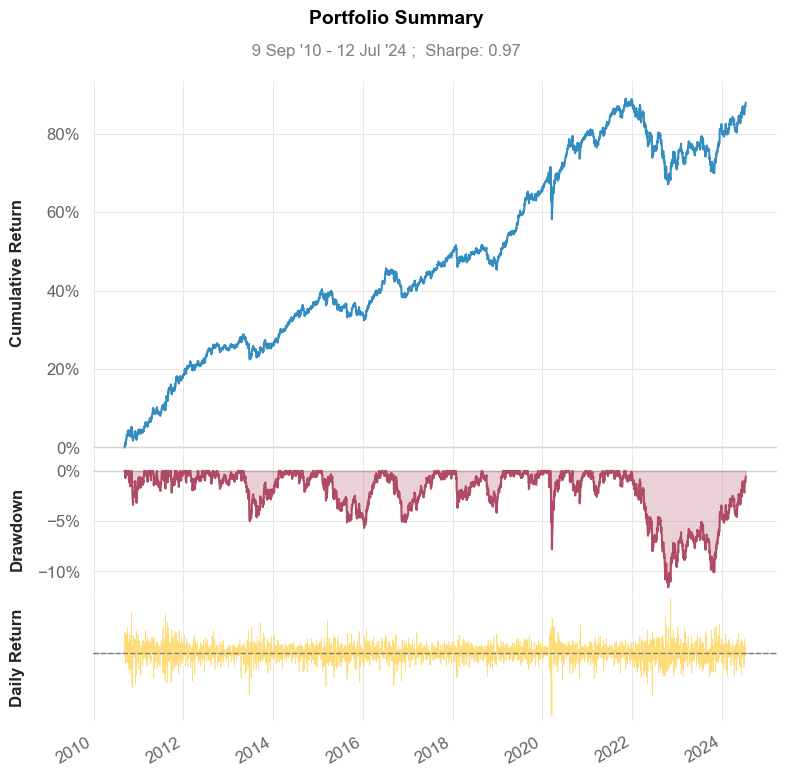

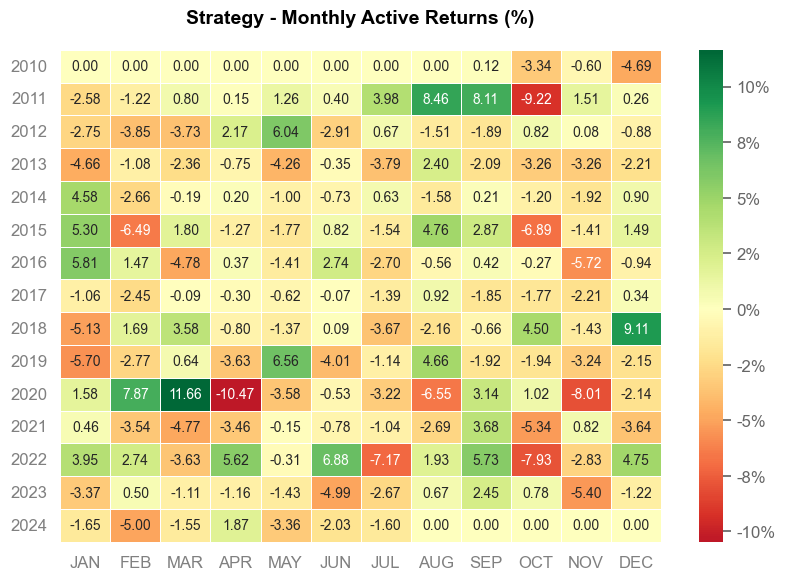

In [ ]:
strategy = portfolio_values["value"].pct_change().fillna(0)
display(strategy)

benchmark = qs.utils.download_returns('SPY').fillna(0)
display(benchmark)

qs.reports.basic(strategy, benchmark=benchmark, display=True)